# ARIMA Lab

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

---

## Importing the data

### Data checks: 
After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
# missing data?
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
# data types
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
# n observations
walmart.shape

(421570, 5)

In [6]:
# n unique stores
len(set(walmart['Store']))

45

In [7]:
# n unique departments
len(set(walmart['Dept']))

81

### Creating a datetime index:

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [8]:
walmart['Date'] = pd.to_datetime(walmart['Date'])
walmart = walmart.set_index('Date')

In [9]:
walmart.head(3)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False


### Getting weekly sales for store 1:

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [10]:
# # multiple steps, if preferred:
# store_1 = walmart[walmart['Store'] == 1]
# df = store_1.groupby('Date').sum()[['Weekly_Sales']]

In [11]:
# one-liner
df = walmart[walmart['Store'] == 1].groupby('Date').sum()[['Weekly_Sales']]
df.head(3)

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17


---

## Plotting and interpreting a time series

### Generate a line plot:

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

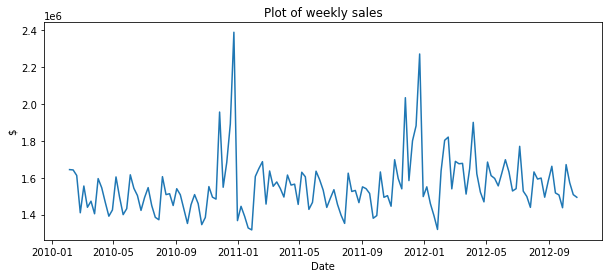

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Plot of weekly sales')
plt.ylabel('$')
plt.xlabel('Date');

### Plotting rolling means:

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

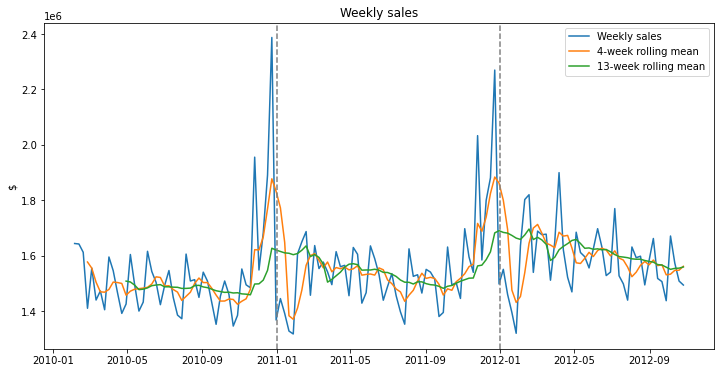

In [13]:
# solution code note - there are multiple ways to do this

# some instructors and students may find it cleaner to save
# the rolled sales as variables and plot those

# title and labels
plt.figure(figsize=(12,6))
plt.title('Weekly sales')
plt.ylabel('$')

# time series plotting
plt.plot(df, label='Weekly sales')
plt.plot(df.rolling(4).mean(), label='4-week rolling mean')
plt.plot(df.rolling(13).mean(), label='13-week rolling mean')

# add vertical lines for start of calendar year
plt.axvline(pd.to_datetime('2011-01-01'), linestyle='--', c='gray')
plt.axvline(pd.to_datetime('2012-01-01'), linestyle='--', c='gray')

plt.legend();

### (Short answer) Describe any trends that you notice:

(Answers may vary)

- There are clear sales spikes around the holidays. It looks like there's a big spike for Black Friday, then a slump, and then an even bigger spike just before Christmas.
- There appears to be seasonality.
- There appears to be an up-and-down pattern.

---

## Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

### Plot and interpret the autocorrelation:

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. What do you notice? (Your answer can be given in bullet points; full sentences are not required.)

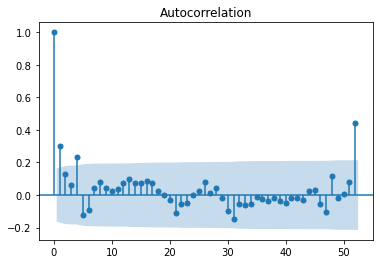

In [14]:
plot_acf(df, lags=52);

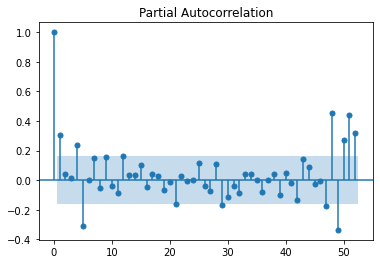

In [15]:
plot_pacf(df, lags=52);

- The autocorrelation drops off pretty quickly. There's a correlation at lag 1 and at lag 4, but then things look pretty noisy until lag 52.
- The partial autocorrelation is also pretty noisy. There's stronger correlations at lags 1 and 4, also a negative correlation at lag 5. Then lags 48 to 52 have strong scores as well.

---

## Modeling

### Train-test splitting:

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [16]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

### Evaluating stationarity:

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [17]:
adfuller(df)

(-5.102186145192288,
 1.3877788330759434e-05,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 3412.7325502876756)

The p-value is below .01; there is sufficient evidence to reject the null hypothesis that the data are non-stationary.

---

### Fit and evaluate an AR(1) model:

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data:

In [18]:
ar = ARIMA(endog=train, order=(1,0,0)).fit()

### Evaluating the model:

#### Store predictions:

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data:

In [19]:
train_preds = ar.predict(start=train.index[0], end=train.index[-1])
test_preds = ar.predict(start=test.index[0], end=test.index[-1])

#### Mean squared error:

Use the `mean_squared_error` function to identify the MSE on the testing data:

In [20]:
mean_squared_error(test, test_preds)

5188882502.372877

#### Generate a plot of the training data, testing data, train preds, and test preds:

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [21]:
def plot_preds(train, test, train_preds, test_preds, suptitle=None, truncate=False):
    
    '''
    
    A convenience function for plotting time series data and time series predictions.
    The variables train, test, train preds, and test preds should have time series
    indices.
    
    suptitle -- an optional argument that adds a super-title to the plot;
        you can use it to specify what model you're plotting predictions
        off of
        
    truncate -- an optional integer argument that truncates how much of the
        training predictions are plotted; specify an integer to not plot
        that many of the first training predictions. (this will most often
        be the integer d, the differencing order.)
        
    '''
    
    plt.figure(figsize=(12,4))

    plt.plot(train, label='training data')
    plt.plot(test, label='testing data')
    
    if truncate:
        plt.plot(train_preds.iloc[truncate:], linestyle='--', label='training preds')
    else:
        plt.plot(train_preds, linestyle='--', label='training preds')
    plt.plot(test_preds, linestyle='--', label='testing preds')

    plt.title('Walmart weekly sales')
    if suptitle:
        plt.suptitle(suptitle)
    plt.legend();

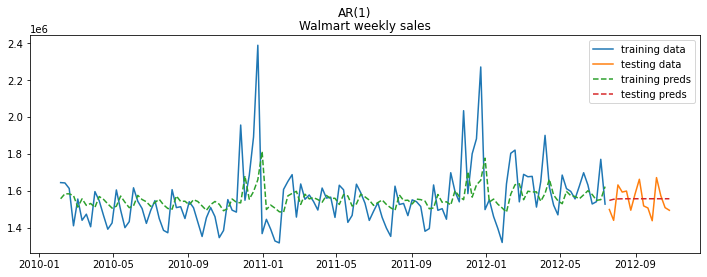

In [22]:
plot_preds(train, test, train_preds, test_preds, 'AR(1)')

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

(Your answer here.) It is not a very good model.

---

### Fit and evaluate an ARMA(2,2) model:

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [23]:
arma = ARIMA(endog=train, order=(2,0,2)).fit()

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [24]:
train_preds = arma.predict(start=train.index[0], end=train.index[-1])
test_preds = arma.predict(start=test.index[0], end=test.index[-1])

#### Mean squared error:

Find the MSE of the testing data:

In [25]:
mean_squared_error(test, test_preds)

5188882502.372877

#### Generate a plot of the training data, testing data, train preds, and test preds:

As before, plot your data and predictions.

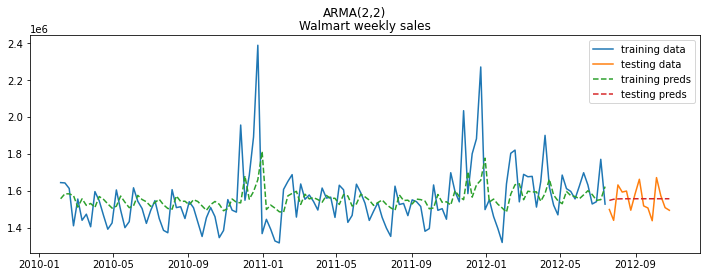

In [26]:
plot_preds(train, test, train_preds, test_preds, 'ARMA(2,2)')

#### Intepretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

(Your answer here.) It is not a very good model.

---

### Fit and evaluate an ARIMA(2,1,2) model:

Instantiate and fit an ARIMA model with order $(2,1,2)$:

In [27]:
arima = ARIMA(endog=train, order=(2,1,2)).fit()

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [28]:
train_preds = arima.predict(start=train.index[0], end=train.index[-1])
test_preds = arima.predict(start=test.index[0], end=test.index[-1])

#### Mean squared error:

Find the MSE on your testing data:

In [29]:
mean_squared_error(test, test_preds)

8383610384.406933

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

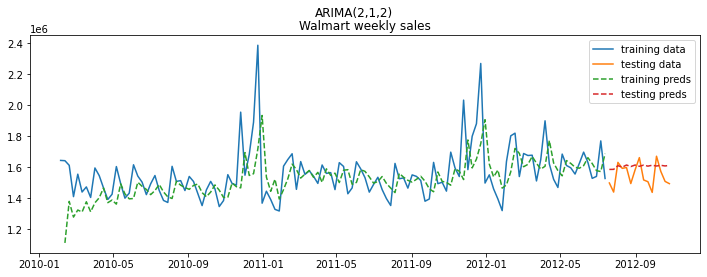

In [30]:
plot_preds(train, test, train_preds, test_preds, 'ARIMA(2,1,2)', truncate=1)

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

(Your answer here.) It is not a very good model.

---

### Fit and evaluate an ARIMA(52,0,1) model:

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$:

In [31]:
arima = ARIMA(endog=train, order=(52,0,1)).fit()

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [32]:
train_preds = arima.predict(start=train.index[0], end=train.index[-1])
test_preds = arima.predict(start=test.index[0], end=test.index[-1])

#### Mean squared error:

Find the MSE on your testing data:

In [33]:
mean_squared_error(test, test_preds)

7894601374.568849

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

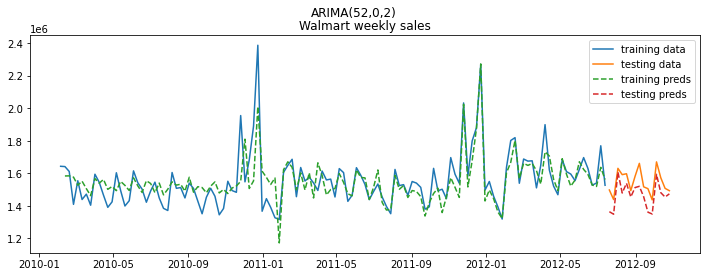

In [34]:
plot_preds(train, test, train_preds, test_preds, 'ARIMA(52,0,2)', truncate=1)

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

(Your answer here)

---

## (BONUS) SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows exogenous data to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

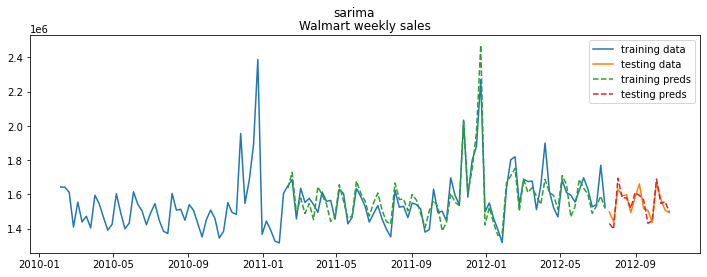

In [35]:
sarima = SARIMAX(train, order=(2,0,2), seasonal_order=(1,1,1,52)).fit()

train_preds = sarima.predict(start=train.index[0], end=train.index[-1])
test_preds = sarima.predict(start=test.index[0], end=test.index[-1])

plot_preds(train, test, train_preds, test_preds, 'sarima', truncate=53)